In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, find_peaks, detrend, savgol_filter
from scipy.fft import rfft, rfftfreq

In [3]:
# Ganti nama file kalau beda
df = pd.read_csv("0009_8min_signal.csv")

# Sesuaikan nama kolom jika berbeda
ppg = df['pleth_y'].astype(float).values
co2 = df['co2_y'].astype(float).values

fs = 300  # sampling rate CapnoBase
T  = len(ppg) / fs
print(f"Durasi sinyal: {T/60:.2f} menit")

Durasi sinyal: 8.00 menit


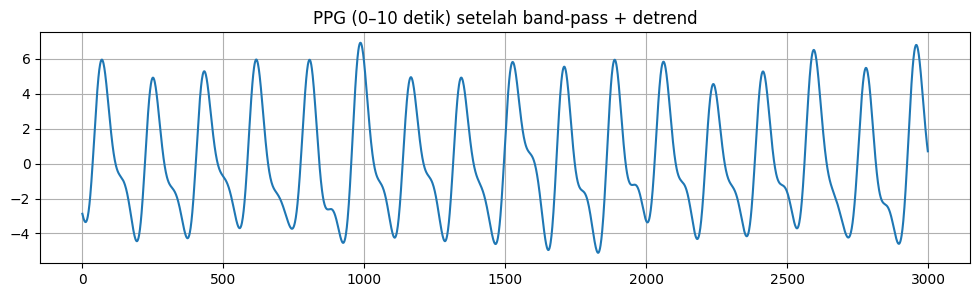

In [4]:
def bandpass(signal, fs, lowcut=0.7, highcut=4.0, order=3):
    b, a = butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

ppg_filt = bandpass(ppg, fs)
ppg_det  = detrend(ppg_filt)  # hilangkan drift pelan

plt.figure(figsize=(12,3))
plt.plot(ppg_det[:3000])
plt.title("PPG (0–10 detik) setelah band-pass + detrend")
plt.grid(True)
plt.show()

In [5]:
def extract_hr_from_ppg(ppg_win, fs):
    # threshold adaptif + prominence
    thr = np.percentile(ppg_win, 75)
    peaks, _ = find_peaks(
        ppg_win,
        distance=0.35 * fs,          # max HR ~ 170 bpm
        height=thr,
        prominence=(np.std(ppg_win) * 0.3)
    )

    if len(peaks) < 4:
        return None, None, None  # terlalu sedikit beat

    t_peaks = peaks / fs
    ibi     = np.diff(t_peaks)          # detik
    hr      = 60.0 / ibi                # BPM
    t_hr    = t_peaks[1:]               # waktu untuk tiap HR

    # smoothing HR supaya surrogate lebih halus
    if len(hr) >= 11:
        hr_smooth = savgol_filter(hr, window_length=11, polyorder=3)
    else:
        hr_smooth = hr

    return t_hr, hr_smooth, ibi


In [6]:
def extract_surrogates(ppg_win, t_hr, hr_smooth, ibi, fs):
    # Puncak PPG di window yang sama
    thr = np.percentile(ppg_win, 75)
    peaks, _ = find_peaks(
        ppg_win,
        distance=0.35 * fs,
        height=thr,
        prominence=(np.std(ppg_win) * 0.3)
    )
    if len(peaks) < 4:
        return None, None, None

    # Detrend PPG dulu, baru ambil amplitudo di puncak
    ppg_detrended = detrend(ppg_win)
    # Cari waktu puncak dalam detik
    t_peaks = peaks / fs

    # Samakan domain waktu HR dan amplitude: pakai interpolasi ke domain t_hr
    RIAV = np.interp(t_hr, t_peaks, ppg_detrended[peaks])

    # RIIV & RIFV: didefinisikan pada titik tengah interval IBI
    t_ibi_mid = (t_hr[:-1] + t_hr[1:]) / 2.0
    ibi_mid   = ibi[1:]               # buang satu supaya align
    hr_mid    = hr_smooth[1:]

    if len(t_ibi_mid) < 4 or len(RIAV) < 4:
        return None, None, None

    # Interpolasi ke domain t_hr supaya semua surrogate punya grid waktu konsisten
    RIIV = np.interp(t_hr, t_ibi_mid, ibi_mid)
    RIFV = np.interp(t_hr, t_ibi_mid, hr_mid)

    # Samakan panjang
    L = min(len(RIAV), len(RIIV), len(RIFV))
    return RIAV[:L], RIIV[:L], RIFV[:L]


In [ ]:
def fourier_product_from_surrogates(RIAV, RIIV, RIFV):
    if len(RIAV) < 8:
        return None

    def norm_and_detrend(x):
        x = (x - np.mean(x)) / (np.std(x) + 1e-8)
        return detrend(x)

    a = norm_and_detrend(RIAV)
    i = norm_and_detrend(RIIV)
    f = norm_and_detrend(RIFV)

    # Asumsikan "sampling" surrogate kira-kira per-beat → dt = rata-rata IBI
    # Tapi kita pakai domain t indeks HR (lebih stabil)
    N = len(a)
    # misal sampling ~ 2 Hz (domestik, kira2 HR 60–100 → 1–1.6 beat/s)
    # Supaya konsisten, kita paksa dt = 0.5 s → fs_sur = 2 Hz
    dt = 0.5
    freqs = rfftfreq(N, dt)

    A_fft = np.abs(rfft(a))
    I_fft = np.abs(rfft(i))
    F_fft = np.abs(rfft(f))

    # L2 norm normalisasi
    A_fft /= (np.linalg.norm(A_fft) + 1e-8)
    I_fft /= (np.linalg.norm(I_fft) + 1e-8)
    F_fft /= (np.linalg.norm(F_fft) + 1e-8)

    P = A_fft * I_fft * F_fft

    # Cari puncak di rentang RR fisiologis 0.1–0.5 Hz (6–30 bpm)
    mask = (freqs >= 0.1) & (freqs <= 0.5)
    if not np.any(mask):
        return None

    f_sub = freqs[mask]
    P_sub = P[mask]

    idx_peak = np.argmax(P_sub)
    f_peak   = f_sub[idx_peak]

    RR_est = f_peak * 60.0
    return RR_est, freqs, P

In [ ]:
def rr_ground_truth_from_co2(co2_win, fs):
    peaks, _ = find_peaks(
        co2_win,
        distance=0.7 * fs,           # min jarak antar napas ~0.7s (~85 bpm resp, tinggi bgt)
        prominence=(np.std(co2_win) * 0.3)
    )
    if len(peaks) < 2:
        return None

    ibi_resp = np.diff(peaks) / fs
    RR = 60.0 / np.mean(ibi_resp)
    return RR

In [9]:
win_sec  = 40   # panjang window
step_sec = 5    # geser 5 detik

RR_est_all = []
RR_gt_all  = []
t_center   = []

for start_sec in range(0, int(T - win_sec), step_sec):
    start_idx = int(start_sec * fs)
    end_idx   = int((start_sec + win_sec) * fs)

    ppg_win = ppg_det[start_idx:end_idx]
    co2_win = co2[start_idx:end_idx]

    # 1) HR dari PPG window
    t_hr, hr_smooth, ibi = extract_hr_from_ppg(ppg_win, fs)
    if t_hr is None:
        continue

    # 2) Surrogate
    sur = extract_surrogates(ppg_win, t_hr, hr_smooth, ibi, fs)
    if sur[0] is None:
        continue
    RIAV, RIIV, RIFV = sur

    # 3) Fourier Product RR
    fp_res = fourier_product_from_surrogates(RIAV, RIIV, RIFV)
    if fp_res is None:
        continue
    RR_est, freqs_fp, P_fp = fp_res

    # 4) RR ground truth dari CO2
    RR_gt = rr_ground_truth_from_co2(co2_win, fs)
    if RR_gt is None:
        continue

    RR_est_all.append(RR_est)
    RR_gt_all.append(RR_gt)
    t_center.append(start_sec + win_sec/2)

RR_est_all = np.array(RR_est_all)
RR_gt_all  = np.array(RR_gt_all)
t_center   = np.array(t_center)

print("Jumlah window valid:", len(RR_est_all))


Jumlah window valid: 88


MAE RR (Fourier Product vs CO2): 4.29 BPM


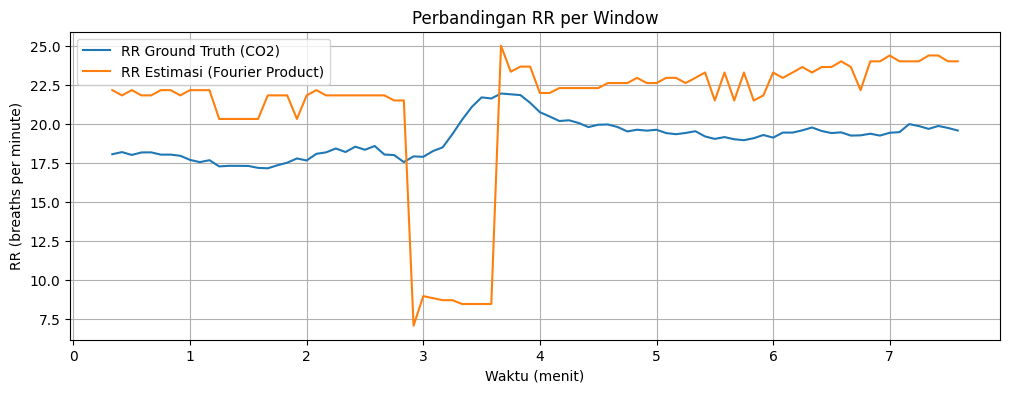

In [ ]:
if len(RR_est_all) > 0:
    mae = np.mean(np.abs(RR_est_all - RR_gt_all))
    print(f"MAE RR (Fourier Product vs CO2): {mae:.2f} BPM")

    plt.figure(figsize=(12,4))
    plt.plot(t_center/60, RR_gt_all, label="RR Ground Truth (CO2)")
    plt.plot(t_center/60, RR_est_all, label="RR Estimasi (Fourier Product)")
    plt.xlabel("Waktu (menit)")
    plt.ylabel("RR (breaths per minute)")
    plt.title("Perbandingan RR per Window")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Tidak ada window valid.")